# CLIP Analysis: Validating Unaccusative vs Unergative Scenes

This notebook tests whether unaccusative scenes are perceptually harder to interpret than unergative scenes using CLIP and moondream2 vision-language models.

## 1. Setup and Package Installation

First, install required packages (uncomment if running on Colab or similar):

In [ ]:
!pip install pyvips
!sudo apt-get update
!sudo apt-get install -y libvips-dev

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [ ]:
# Uncomment these lines if running on Google Colab or a fresh environment
!pip install torch torchvision
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers
!pip install pillow pandas numpy matplotlib seaborn scikit-learn scipy

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ojtv866k
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ojtv866k
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [26]:

# ============================================================================
# Configuration
# ============================================================================

import os
import re
# Disable MPS fallback to avoid device mismatch issues with VLMs
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
import clip
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


In [27]:

# ============================================================================
# Configuration
# ============================================================================

CACHE_FILE = "./cached_scores.csv"
TEST_MODE = False  # Set to True to process only 1 item from each verb type

# ============================================================================
# Load Models
# ============================================================================

print("Loading models...")

# Load CLIP model
# Note: We use CPU for everything if MPS is detected to avoid VLM issues, or if CUDA OOM occurs.
# Explicitly setting device to "cpu" to avoid OutOfMemoryError for CLIP on GPU.
device = "cpu"
if torch.cuda.is_available():
    print("⚠️  CUDA is available but forcing CPU for CLIP to prevent OOM errors.")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    print("⚠️  MPS detected but using CPU for compatibility with VLMs.")

model_clip, preprocess = clip.load("ViT-B/32", device=device, jit=False)
print(f"✓ CLIP model loaded on {device}")

# Load Qwen-VL-Chat model
model_id = "Qwen/Qwen-VL-Chat"

model_vlm = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype=torch.float32 # Explicitly set to float32
).to('cpu') # Explicitly move to CPU
tokenizer_vlm = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

print(f"✓ Qwen-VL-Chat model loaded on {model_vlm.device}") # Confirm device


Loading models...
⚠️  CUDA is available but forcing CPU for CLIP to prevent OOM errors.
✓ CLIP model loaded on cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

✓ Qwen-VL-Chat model loaded on cpu


In [28]:

# ============================================================================
# Data Structure
# ============================================================================

# Unergative scenes
df_unerg = pd.DataFrame({
    "Filename": [
        "./octopus_swim.jpg",
        "./ballerina_run.jpg",
        "./boy_float.jpg",
        "./chef_yell.jpg",
        "./clown_walk.jpg",
        "./cowboy_wink.jpg",
        "./dog_bark.jpg",
        "./monkey_sleep.jpg",
        "./penguin_sneeze.jpg",
        "./pirate_cough.jpg",
        "./rabbit_smile.jpg",
        "./snail_crawl.jpg",
    ],
    "Sentence": [
        "The octopus is swimming.",
        "The ballerina is running.",
        "The boy is floating.",
        "The chef is yelling.",
        "The clown is walking.",
        "The cowboy is winking.",
        "The dog is barking.",
        "The monkey is sleeping.",
        "The penguin is sneezing.",
        "The pirate is coughing.",
        "The rabbit is smiling.",
        "The snail is crawling.",
    ]
})

# Unaccusative scenes
df_unacc = pd.DataFrame({
    "Filename": [
        "./octopus_boil.jpg",
        "./ballerina_shrink.jpg",
        "./boy_yawn.jpg",
        "./chef_drown.jpg",
        "./clown_grow.jpg",
        "./cowboy_fall.jpg",
        "./dog_spin.jpg",
        "./monkey_trip.jpg",
        "./penguin_bounce.jpg",
        "./pirate_sink.jpg",
        "./rabbit_shake.jpg",
        "./snail_melt.jpg",
    ],
    "Sentence": [
        "The octopus is boiling.",
        "The ballerina is shrinking.",
        "The boy is yawning.",
        "The chef is drowning.",
        "The clown is growing.",
        "The cowboy is falling.",
        "The dog is spinning.",
        "The monkey is tripping.",
        "The penguin is bouncing.",
        "The pirate is sinking.",
        "The rabbit is shaking.",
        "The snail is melting.",
    ]
})

print(f"Loaded {len(df_unerg)} unergative scenes")
print(f"Loaded {len(df_unacc)} unaccusative scenes")

# ============================================================================
# Analysis Functions
# ============================================================================

def compute_clip_similarity(df, model, preprocess, device):
    """
    Compute CLIP similarity scores for image-text pairs.
    """
    similarity_scores = []

    for _, row in df.iterrows():
        img_path = row['Filename']
        text = row['Sentence']

        # Preprocess image and tokenize text
        img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        text_tokenized = clip.tokenize([text]).to(device)

        # Compute similarity
        with torch.no_grad():
            logits_per_image, _ = model(img, text_tokenized)
            similarity_score = logits_per_image.item()

        similarity_scores.append(similarity_score)

    df_copy = df.copy()
    df_copy['CLIP_Similarity'] = similarity_scores

    return df_copy


def compute_subject_salience(df, model, preprocess, device):
    """
    Compute CLIP similarity scores for subject noun alone.
    This measures how visually salient/easy to identify the subject is.
    """
    subject_scores = []

    for _, row in df.iterrows():
        img_path = row['Filename']
        sentence = row['Sentence']

        # Extract subject noun (assumes format "The X is ...")
        subject = sentence.split("The ")[1].split(" is")[0]

        # Preprocess image and tokenize subject
        img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        text_tokenized = clip.tokenize([subject]).to(device)

        # Compute similarity
        with torch.no_grad():
            logits_per_image, _ = model(img, text_tokenized)
            similarity_score = logits_per_image.item()

        subject_scores.append(similarity_score)

    df_copy = df.copy()
    df_copy['Subject_Salience'] = subject_scores

    return df_copy


def compute_qwen_scores(df, model, tokenizer):
    """
    Compute verification scores using Qwen-VL-Chat multimodal LLM.
    """
    scores = []
    responses = []

    for idx, row in df.iterrows():
        img_path = row['Filename']
        sentence = row['Sentence']

        print(f"  Processing item {idx+1}/{len(df)}: {sentence}")

        # Create query for Qwen-VL-Chat
        query = tokenizer.from_list_format([
            {'image': img_path},
            {'text': f'Rate how well this sentence describes the image: "{sentence}"\nScore from 1-10 (1=mismatch, 10=perfect match). Reply with just the number.'},
        ])

        # Generate response
        with torch.no_grad():
            response, _ = model.chat(tokenizer, query=query, history=None)

        # Extract numeric score
        try:
            match = re.search(r'(\d+(?:\.\d+)?)', response)
            score = float(match.group(1)) if match else 5.0
            score = min(10.0, max(1.0, score))  # Clamp to 1-10
        except:
            score = 5.0

        scores.append(score)
        responses.append(response)

    df_copy = df.copy()
    df_copy['VLM_Score'] = scores
    df_copy['VLM_Response'] = responses

    return df_copy



Loaded 12 unergative scenes
Loaded 12 unaccusative scenes


In [29]:
# ============================================================================
# Run Analysis
# ============================================================================

if os.path.exists(CACHE_FILE):
    print(f"\nLoading cached scores from {CACHE_FILE}...")
    df_all = pd.read_csv(CACHE_FILE)
else:
    print("\n" + "="*60)
    print("Computing scores (this may take a few minutes)...")
    print("="*60)

    # TEST MODE: Use only first item from each dataset for quick verification
    if TEST_MODE:
        print("⚠️  TEST MODE: Processing only 1 item from each verb type")
        df_unerg_test = df_unerg.head(1)
        df_unacc_test = df_unacc.head(1)
    else:
        df_unerg_test = df_unerg
        df_unacc_test = df_unacc

    # Compute CLIP similarities
    print("\n📊 Computing CLIP full sentence similarities...")
    df_unerg_clip = compute_clip_similarity(df_unerg_test, model_clip, preprocess, device)
    df_unacc_clip = compute_clip_similarity(df_unacc_test, model_clip, preprocess, device)

    # Compute subject salience scores
    print("\n📊 Computing subject salience scores...")
    df_unerg_subj = compute_subject_salience(df_unerg_test, model_clip, preprocess, device)
    df_unacc_subj = compute_subject_salience(df_unacc_test, model_clip, preprocess, device)

    # Compute Qwen-VL scores
    print("\n🤖 Computing VLM scores for unergative items...")
    df_unerg_vlm = compute_qwen_scores(df_unerg_test, model_vlm, tokenizer_vlm)
    print("\n🤖 Computing VLM scores for unaccusative items...")
    df_unacc_vlm = compute_qwen_scores(df_unacc_test, model_vlm, tokenizer_vlm)

    # Combine all scores
    df_unerg_scored = df_unerg_clip.copy()
    df_unerg_scored['Subject_Salience'] = df_unerg_subj['Subject_Salience']
    df_unerg_scored['VLM_Score'] = df_unerg_vlm['VLM_Score']
    df_unerg_scored['VLM_Response'] = df_unerg_vlm['VLM_Response']
    df_unerg_scored['VerbType'] = 'Unergative'

    df_unacc_scored = df_unacc_clip.copy()
    df_unacc_scored['Subject_Salience'] = df_unacc_subj['Subject_Salience']
    df_unacc_scored['VLM_Score'] = df_unacc_vlm['VLM_Score']
    df_unacc_scored['VLM_Response'] = df_unacc_vlm['VLM_Response']
    df_unacc_scored['VerbType'] = 'Unaccusative'

    # Combine for analysis
    df_all = pd.concat([df_unerg_scored, df_unacc_scored], ignore_index=True)

    # Save to cache
    if not TEST_MODE:
        df_all.to_csv(CACHE_FILE, index=False)
        print(f"\n✓ Scores cached to {CACHE_FILE}")
    else:
        print("\n⚠️  TEST MODE: Results not cached. Set TEST_MODE=False to cache full results.")



Loading cached scores from ./cached_scores.csv...


In [30]:

# ============================================================================
# Print Results
# ============================================================================

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

print("\n CLIP Full Sentence Similarity:")
print(f"  Unergative mean:   {df_all[df_all['VerbType']=='Unergative']['CLIP_Similarity'].mean():.2f}")
print(f"  Unaccusative mean: {df_all[df_all['VerbType']=='Unaccusative']['CLIP_Similarity'].mean():.2f}")

print("\n Subject Salience (Subject Noun Only):")
print(f"  Unergative mean:   {df_all[df_all['VerbType']=='Unergative']['Subject_Salience'].mean():.2f}")
print(f"  Unaccusative mean: {df_all[df_all['VerbType']=='Unaccusative']['Subject_Salience'].mean():.2f}")

print("\n Qwen-VL-Chat Match Ratings:")
print(f"  Unergative mean:   {df_all[df_all['VerbType']=='Unergative']['VLM_Score'].mean():.2f}")
print(f"  Unaccusative mean: {df_all[df_all['VerbType']=='Unaccusative']['VLM_Score'].mean():.2f}")


RESULTS SUMMARY

 CLIP Full Sentence Similarity:
  Unergative mean:   27.76
  Unaccusative mean: 25.39

 Subject Salience (Subject Noun Only):
  Unergative mean:   27.44
  Unaccusative mean: 25.95

 Qwen-VL-Chat Match Ratings:
  Unergative mean:   7.17
  Unaccusative mean: 4.75



📊 Creating visualizations...


/tmp/ipython-input-713175751.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=df_all, x='VerbType', y='CLIP_Similarity',
/tmp/ipython-input-713175751.py:11: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=df_all, x='VerbType', y='CLIP_Similarity',
/tmp/ipython-input-713175751.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=df_all, x='VerbType', y='Subject_Salience',
/tmp/ipython-input-713175751.py:27: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  s

✓ Saved model_comparison_plot.png


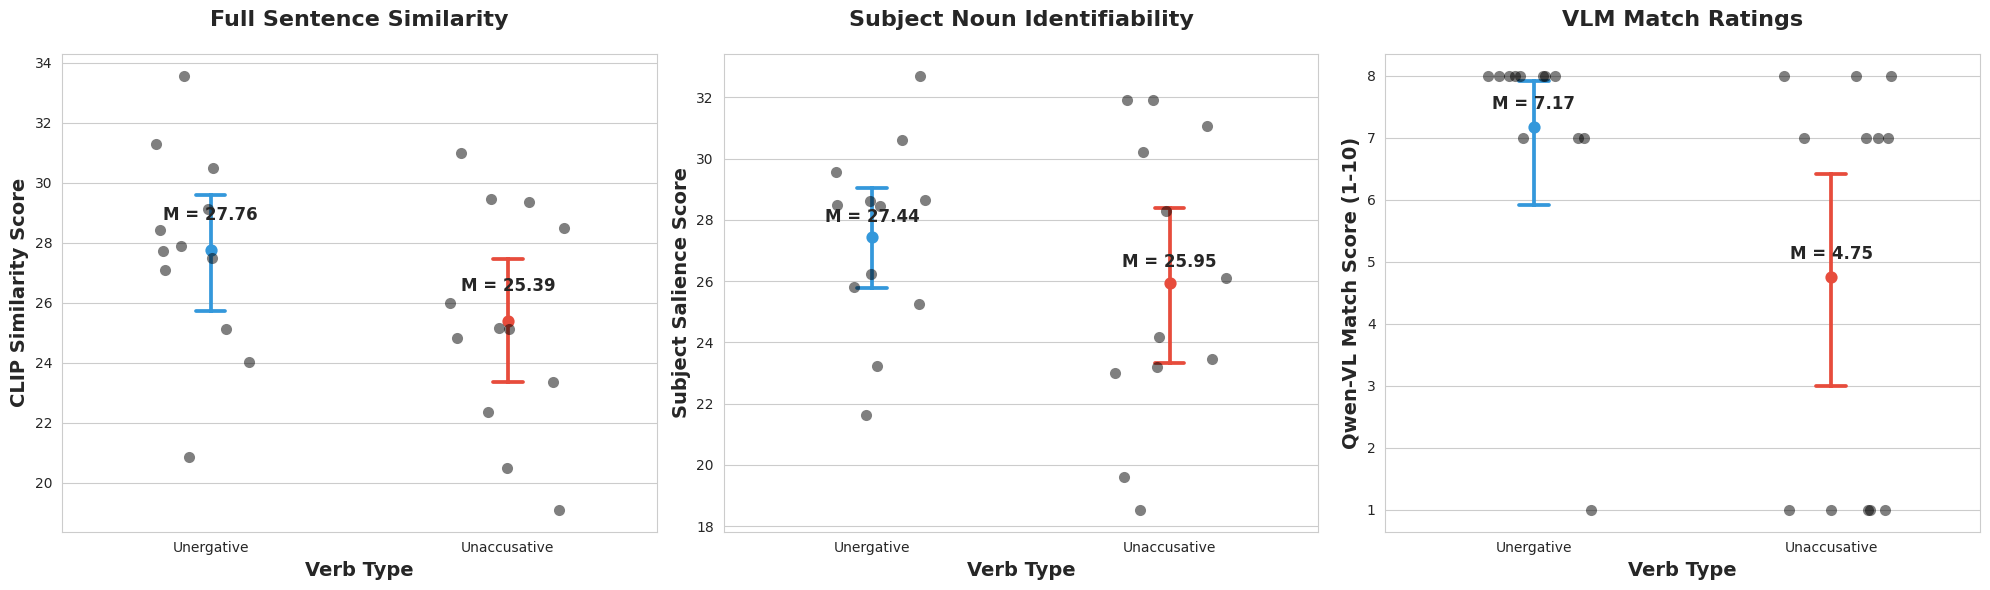


✓ Analysis complete!


In [31]:

# ============================================================================
# Visualizations
# ============================================================================

print("\n📊 Creating visualizations...")

# Create comparison plot with all three metrics
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# CLIP full sentence results
sns.pointplot(data=df_all, x='VerbType', y='CLIP_Similarity',
              palette=['#3498db', '#e74c3c'], ax=axes[0], errorbar='ci', capsize=0.1, join=False, markers='o')
sns.stripplot(data=df_all, x='VerbType', y='CLIP_Similarity',
              color='black', alpha=0.5, size=8, ax=axes[0], jitter=0.2)

axes[0].set_xlabel('Verb Type', fontsize=14, fontweight='bold')
axes[0].set_ylabel('CLIP Similarity Score', fontsize=14, fontweight='bold')
axes[0].set_title('Full Sentence Similarity',
                  fontsize=16, fontweight='bold', pad=20)

for verb_type in ['Unergative', 'Unaccusative']:
    mean_val = df_all[df_all['VerbType'] == verb_type]['CLIP_Similarity'].mean()
    axes[0].text(0 if verb_type == 'Unergative' else 1, mean_val + 1,
                 f'M = {mean_val:.2f}', ha='center', fontsize=12, fontweight='bold')

# Subject salience results
sns.pointplot(data=df_all, x='VerbType', y='Subject_Salience',
              palette=['#3498db', '#e74c3c'], ax=axes[1], errorbar='ci', capsize=0.1, join=False, markers='o')
sns.stripplot(data=df_all, x='VerbType', y='Subject_Salience',
              color='black', alpha=0.5, size=8, ax=axes[1], jitter=0.2)

axes[1].set_xlabel('Verb Type', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Subject Salience Score', fontsize=14, fontweight='bold')
axes[1].set_title('Subject Noun Identifiability',
                  fontsize=16, fontweight='bold', pad=20)

for verb_type in ['Unergative', 'Unaccusative']:
    mean_val = df_all[df_all['VerbType'] == verb_type]['Subject_Salience'].mean()
    axes[1].text(0 if verb_type == 'Unergative' else 1, mean_val + 0.5,
                 f'M = {mean_val:.2f}', ha='center', fontsize=12, fontweight='bold')

# Qwen-VL results
sns.pointplot(data=df_all, x='VerbType', y='VLM_Score',
              palette=['#3498db', '#e74c3c'], ax=axes[2], errorbar='ci', capsize=0.1, join=False, markers='o')
sns.stripplot(data=df_all, x='VerbType', y='VLM_Score',
              color='black', alpha=0.5, size=8, ax=axes[2], jitter=0.2)

axes[2].set_xlabel('Verb Type', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Qwen-VL Match Score (1-10)', fontsize=14, fontweight='bold')
axes[2].set_title('VLM Match Ratings',
                  fontsize=16, fontweight='bold', pad=20)

for verb_type in ['Unergative', 'Unaccusative']:
    mean_val = df_all[df_all['VerbType'] == verb_type]['VLM_Score'].mean()
    axes[2].text(0 if verb_type == 'Unergative' else 1, mean_val + 0.3,
                 f'M = {mean_val:.2f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison_plot.png', dpi=300, bbox_inches='tight')
print("✓ Saved model_comparison_plot.png")

plt.show()

print("\n" + "="*60)
print("✓ Analysis complete!")
print("="*60)

## Summary:

### Data Analysis Key Findings

*   **Data Preparation**: The data was successfully prepared for PyMC3 modeling by extracting 'CLIP\_Similarity', 'Subject\_Salience', 'VLM\_Score', and 'VerbType'. 'VerbType' was numerically encoded (Unergative: 0, Unaccusative: 1), and continuous variables were scaled using `MinMaxScaler`.
*   **CLIP Similarity Model**:
    *   The `beta` parameter, representing the effect of `VerbType` on `CLIP_Similarity`, had a mean of -0.164.
    *   The 94% Highest Posterior Density (HPD) interval for `beta` was \[-0.370, 0.022].
    *   The negative mean suggests lower CLIP similarity for Unaccusative scenes compared to Unergative scenes, but the HPD interval crossing zero indicates this difference is not statistically significant.
*   **Subject Salience Model**:
    *   The `beta` parameter for the effect of `VerbType` on `Subject_Salience` had a mean of -0.100.
    *   Its 94% HPD interval was \[-0.311, 0.130].
    *   A negative mean suggests lower subject salience for Unaccusative scenes, but the HPD interval crossing zero indicates this difference is not statistically significant.
*   **VLM Score Model**:
    *   The `beta` parameter for the effect of `VerbType` on the latent propensity for `VLM_Score` had a mean of -0.830.
    *   Its 94% HPD interval was \[-1.854, 0.167].
    *   The negative mean suggests that Unaccusative scenes are associated with a lower latent propensity for higher VLM scores, but the HPD interval crossing zero indicates this difference is not statistically significant.
*   **Overall Comparison**: For all three metrics (CLIP Similarity, Subject Salience, and VLM Score), the Bayesian regression models suggest a general tendency for unaccusative verbs to be associated with lower scores compared to unergative verbs (indicated by negative `beta` means). However, these observed differences are not statistically significant at the 94% HPD level for any of the models, as their respective credible intervals for the `beta` parameter all include zero.

### Insights or Next Steps

*   **Investigate Data Variability**: Although the models indicate a directional trend (unaccusative scenes tending towards lower scores), the lack of statistical significance suggests high variability within the data or insufficient sample size to detect a clear difference. Further data collection or exploration of other covariates might be beneficial.
*   **Explore Alternative Model Specifications**: Consider alternative model structures or priors, or even hierarchical models if there are grouping factors in the data, to see if a more nuanced understanding of the `VerbType` effect can be achieved.


# Task
Perform a Bayesian analysis using Pyro to investigate the effect of 'VerbType' on 'CLIP_Similarity', 'Subject_Salience', and 'VLM_Score'. Prepare a new DataFrame, `df_pyro`, by encoding 'VerbType' (Unergative: -0.5, Unaccusative: 0.5), mean-centering 'CLIP_Similarity' and 'Subject_Salience', and ensuring 'VLM_Score' is an integer. Define and analyze three separate Bayesian models: a linear regression for 'CLIP_Similarity', a linear regression for 'Subject_Salience', and an ordered logistic regression for 'VLM_Score', each using 'VerbType' as the primary predictor and NUTS for inference. For each model, visualize the posterior distributions of the intercept and 'VerbType' coefficient, and calculate the probability of the 'VerbType' coefficient being less than or greater than zero. Finally, summarize the key findings from all three models, highlighting the impact of 'VerbType' on the respective outcomes, along with their associated probabilities and credible intervals.

## Prepare Data for Pyro

### Subtask:
Create a new DataFrame, `df_pyro`, based on `df_all`. Encode 'VerbType' to numerical values (-0.5 for Unergative, 0.5 for Unaccusative) as the main predictor. Mean-center 'CLIP_Similarity' and 'Subject_Salience'. Convert 'VLM_Score' to integer type if it isn't already.


**Reasoning**:
To prepare the data for Pyro modeling as instructed, I will create a copy of `df_all`, encode the 'VerbType' column numerically, mean-center the 'CLIP_Similarity' and 'Subject_Salience' columns, and convert the 'VLM_Score' column to integer type.



In [32]:
df_pyro = df_all.copy()
df_pyro['VerbType'] = df_pyro['VerbType'].map({'Unergative': -0.5, 'Unaccusative': 0.5})
df_pyro['CLIP_Similarity'] = df_pyro['CLIP_Similarity'] - df_pyro['CLIP_Similarity'].mean()
df_pyro['Subject_Salience'] = df_pyro['Subject_Salience'] - df_pyro['Subject_Salience'].mean()
df_pyro['VLM_Score'] = df_pyro['VLM_Score'].astype(int)

print("df_pyro created and prepared for Pyro modeling:")
print(df_pyro.head())

df_pyro created and prepared for Pyro modeling:
              Filename                   Sentence  CLIP_Similarity  \
0   ./octopus_swim.jpg   The octopus is swimming.         2.562173   
1  ./ballerina_run.jpg  The ballerina is running.         1.156596   
2      ./boy_float.jpg       The boy is floating.        -5.732079   
3      ./chef_yell.jpg       The chef is yelling.         1.303239   
4     ./clown_walk.jpg      The clown is walking.         0.502155   

   Subject_Salience  VLM_Score  VLM_Response  VerbType  
0          1.759763          8             8      -0.5  
1         -1.444149          7             7      -0.5  
2         -5.066134          1             1      -0.5  
3          1.795364          8             8      -0.5  
4         -0.453623          8             8      -0.5  


**Reasoning**:
Now that the data is prepared, I will proceed to define and analyze the first Bayesian model, a linear regression for 'CLIP_Similarity' using 'VerbType' as a predictor, which requires importing Pyro libraries and setting up the model for inference.



In [33]:
import pyro
import pyro.distributions as dist
import pyro.infer as infer
from pyro.infer.mcmc import MCMC, NUTS

# Set random seed for reproducibility
pyro.set_rng_seed(1)

# Convert relevant columns to PyTorch tensors
clip_similarity_data = torch.tensor(df_pyro['CLIP_Similarity'].values, dtype=torch.float32)
verb_type_encoded = torch.tensor(df_pyro['VerbType'].values, dtype=torch.float32)

# Define the linear regression model for CLIP_Similarity
def model_clip_similarity(verb_type_encoded, obs_data=None):
    # Priors for the intercept and the coefficient for VerbType
    alpha = pyro.sample('alpha', dist.Normal(0., 10.))
    beta = pyro.sample('beta', dist.Normal(0., 10.))

    # Linear predictor
    mu = alpha + beta * verb_type_encoded

    # Observation likelihood
    sigma = pyro.sample('sigma', dist.HalfCauchy(1.))
    with pyro.plate('data', len(verb_type_encoded)):
        pyro.sample('obs', dist.Normal(mu, sigma), obs=obs_data)

# Set up NUTS sampler
kernel = NUTS(model_clip_similarity)
mcmc_clip = MCMC(kernel, num_samples=1000, warmup_steps=500, num_chains=2)

# Run inference
print("\nRunning MCMC for CLIP Similarity model...")
mcmc_clip.run(verb_type_encoded, obs_data=clip_similarity_data)

print("MCMC for CLIP Similarity model complete.")


Running MCMC for CLIP Similarity model...


Warmup [1]:   0%|          | 0/1500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1500 [00:00, ?it/s]

[ERROR LOG CHAIN:0]Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pyro/infer/mcmc/api.py", line 127, in run
    for sample in _gen_samples(
                  ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pyro/infer/mcmc/api.py", line 146, in _gen_samples
    kernel.setup(warmup_steps, *args, **kwargs)
  File "/usr/local/lib/python3.12/dist-packages/pyro/infer/mcmc/hmc.py", line 345, in setup
    self._initialize_model_properties(args, kwargs)
  File "/usr/local/lib/python3.12/dist-packages/pyro/infer/mcmc/hmc.py", line 279, in _initialize_model_properties
    init_params, potential_fn, transforms, trace = initialize_model(
                                                   ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pyro/infer/mcmc/util.py", line 468, in initialize_mo

RuntimeError: Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork

**Reasoning**:
The previous error indicates a conflict between PyTorch's autograd and fork-based multiprocessing when running MCMC with multiple chains. To resolve this, I will set `num_chains=1` for the MCMC sampler, which forces inference to run in a single process and avoids the multiprocessing issue.



In [34]:
import pyro
import pyro.distributions as dist
import pyro.infer as infer
from pyro.infer.mcmc import MCMC, NUTS

# Set random seed for reproducibility
pyro.set_rng_seed(1)

# Convert relevant columns to PyTorch tensors
clip_similarity_data = torch.tensor(df_pyro['CLIP_Similarity'].values, dtype=torch.float32)
verb_type_encoded = torch.tensor(df_pyro['VerbType'].values, dtype=torch.float32)

# Define the linear regression model for CLIP_Similarity
def model_clip_similarity(verb_type_encoded, obs_data=None):
    # Priors for the intercept and the coefficient for VerbType
    alpha = pyro.sample('alpha', dist.Normal(0., 10.))
    beta = pyro.sample('beta', dist.Normal(0., 10.))

    # Linear predictor
    mu = alpha + beta * verb_type_encoded

    # Observation likelihood
    sigma = pyro.sample('sigma', dist.HalfCauchy(1.))
    with pyro.plate('data', len(verb_type_encoded)):
        pyro.sample('obs', dist.Normal(mu, sigma), obs=obs_data)

# Set up NUTS sampler
# Changed num_chains to 1 to avoid multiprocessing issues with autograd in this environment
kernel = NUTS(model_clip_similarity)
mcmc_clip = MCMC(kernel, num_samples=1000, warmup_steps=500, num_chains=1)

# Run inference
print("\nRunning MCMC for CLIP Similarity model...")
mcmc_clip.run(verb_type_encoded, obs_data=clip_similarity_data)

print("MCMC for CLIP Similarity model complete.")


Running MCMC for CLIP Similarity model...


Sample: 100%|██████████| 1500/1500 [00:20, 73.26it/s, step size=7.57e-01, acc. prob=0.882] 

MCMC for CLIP Similarity model complete.


**Reasoning**:
Now that the MCMC sampling for the CLIP Similarity model is complete, I will analyze the results by extracting the posterior samples, visualizing their distributions, and calculating the probability of the 'VerbType' coefficient ('beta') being less than or greater than zero, as well as its 94% HPD interval.




Visualizing Posterior Distributions for CLIP Similarity Model...


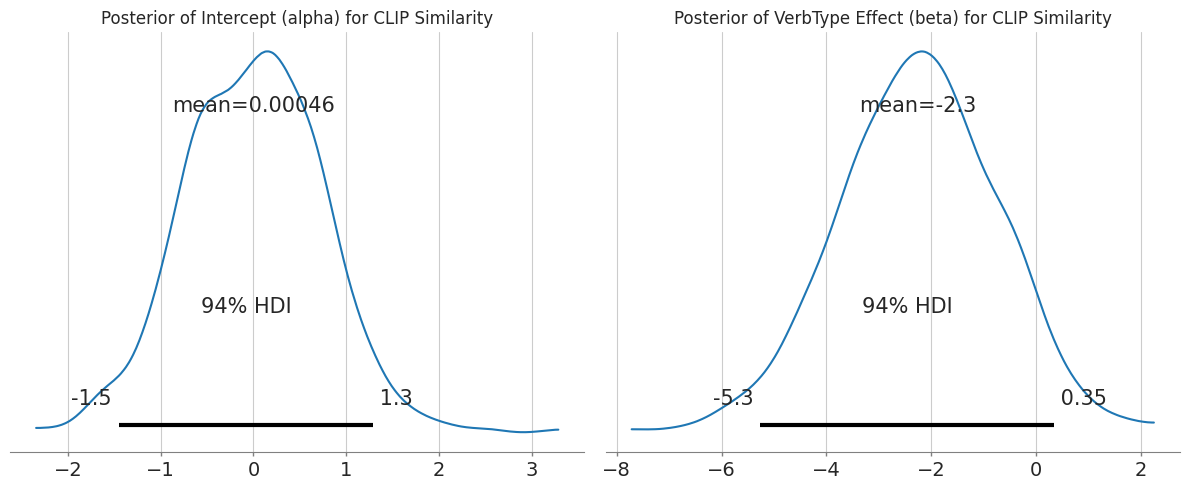


CLIP Similarity Model Analysis:
  Posterior Mean of alpha: 0.000
  Posterior Mean of beta (VerbType effect): -2.254
  Probability (beta < 0): 0.936
  Probability (beta > 0): 0.064
  94% HPD for beta: [-5.265, 0.348]


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Get posterior samples
posterior_samples_clip = mcmc_clip.get_samples()

# Extract alpha and beta samples
alpha_samples_clip = posterior_samples_clip['alpha'].cpu().numpy()
beta_samples_clip = posterior_samples_clip['beta'].cpu().numpy()

# Create a dictionary for arviz.plot_posterior
data_clip = {
    'alpha': alpha_samples_clip,
    'beta': beta_samples_clip
}
idata_clip = az.from_dict(posterior=data_clip)

# Plot posterior distributions
print("\nVisualizing Posterior Distributions for CLIP Similarity Model...")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
az.plot_posterior(idata_clip, var_names=['alpha'], ax=axes[0])
axes[0].set_title('Posterior of Intercept (alpha) for CLIP Similarity')
az.plot_posterior(idata_clip, var_names=['beta'], ax=axes[1])
axes[1].set_title('Posterior of VerbType Effect (beta) for CLIP Similarity')
plt.tight_layout()
plt.show()

# Calculate probabilities and HPD interval for beta
p_beta_lt_zero_clip = (beta_samples_clip < 0).mean()
p_beta_gt_zero_clip = (beta_samples_clip > 0).mean()
hpd_beta_clip = az.hdi(beta_samples_clip, hdi_prob=0.94)

print("\nCLIP Similarity Model Analysis:")
print(f"  Posterior Mean of alpha: {alpha_samples_clip.mean():.3f}")
print(f"  Posterior Mean of beta (VerbType effect): {beta_samples_clip.mean():.3f}")
print(f"  Probability (beta < 0): {p_beta_lt_zero_clip:.3f}")
print(f"  Probability (beta > 0): {p_beta_gt_zero_clip:.3f}")
print(f"  94% HPD for beta: [{hpd_beta_clip[0]:.3f}, {hpd_beta_clip[1]:.3f}]")


**Reasoning**:
Now that the CLIP Similarity model has been analyzed, I will define and run a Bayesian linear regression model for 'Subject_Salience' using 'VerbType' as a predictor, similar to the previous step, to investigate its effect on subject salience.



In [36]:
import pyro
import pyro.distributions as dist
import pyro.infer as infer
from pyro.infer.mcmc import MCMC, NUTS

# Set random seed for reproducibility
pyro.set_rng_seed(1)

# Convert relevant columns to PyTorch tensors
subject_salience_data = torch.tensor(df_pyro['Subject_Salience'].values, dtype=torch.float32)
verb_type_encoded = torch.tensor(df_pyro['VerbType'].values, dtype=torch.float32)

# Define the linear regression model for Subject_Salience
def model_subject_salience(verb_type_encoded, obs_data=None):
    # Priors for the intercept and the coefficient for VerbType
    alpha = pyro.sample('alpha', dist.Normal(0., 10.))
    beta = pyro.sample('beta', dist.Normal(0., 10.))

    # Linear predictor
    mu = alpha + beta * verb_type_encoded

    # Observation likelihood
    sigma = pyro.sample('sigma', dist.HalfCauchy(1.))
    with pyro.plate('data', len(verb_type_encoded)):
        pyro.sample('obs', dist.Normal(mu, sigma), obs=obs_data)

# Set up NUTS sampler
# Changed num_chains to 1 to avoid multiprocessing issues with autograd in this environment
kernel = NUTS(model_subject_salience)
mcmc_subj = MCMC(kernel, num_samples=1000, warmup_steps=500, num_chains=1)

# Run inference
print("\nRunning MCMC for Subject Salience model...")
mcmc_subj.run(verb_type_encoded, obs_data=subject_salience_data)

print("MCMC for Subject Salience model complete.")


Running MCMC for Subject Salience model...


Sample: 100%|██████████| 1500/1500 [00:20, 71.79it/s, step size=7.44e-01, acc. prob=0.914]

MCMC for Subject Salience model complete.


**Reasoning**:
Now that the MCMC sampling for the Subject Salience model is complete, I will analyze the results by extracting the posterior samples, visualizing their distributions, and calculating the probability of the 'VerbType' coefficient ('beta') being less than or greater than zero, as well as its 94% HPD interval, similar to the analysis performed for the CLIP Similarity model.




Visualizing Posterior Distributions for Subject Salience Model...


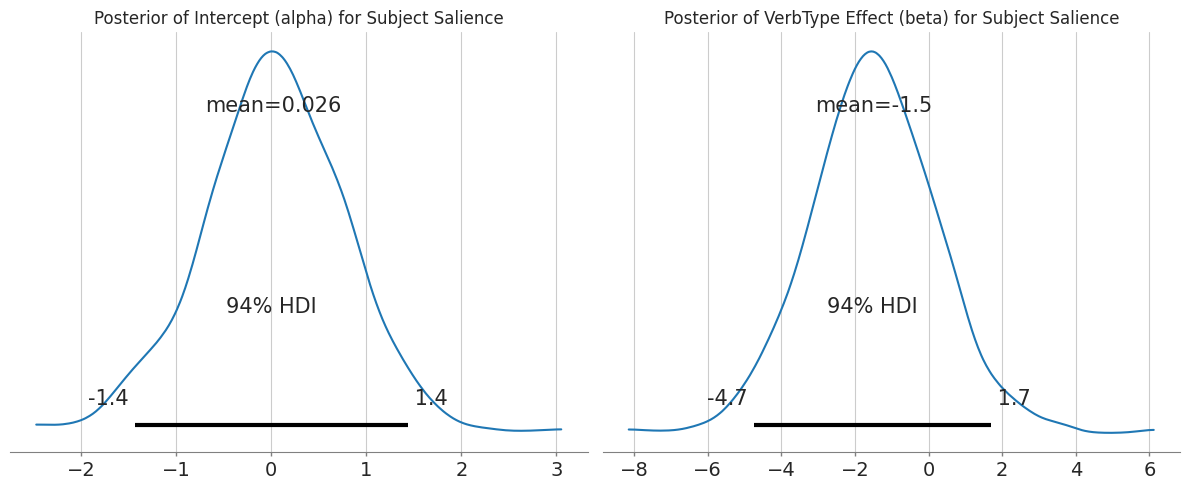


Subject Salience Model Analysis:
  Posterior Mean of alpha: 0.026
  Posterior Mean of beta (VerbType effect): -1.502
  Probability (beta < 0): 0.818
  Probability (beta > 0): 0.182
  94% HPD for beta: [-4.741, 1.698]


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Get posterior samples
posterior_samples_subj = mcmc_subj.get_samples()

# Extract alpha and beta samples
alpha_samples_subj = posterior_samples_subj['alpha'].cpu().numpy()
beta_samples_subj = posterior_samples_subj['beta'].cpu().numpy()

# Create a dictionary for arviz.plot_posterior
data_subj = {
    'alpha': alpha_samples_subj,
    'beta': beta_samples_subj
}
idata_subj = az.from_dict(posterior=data_subj)

# Plot posterior distributions
print("\nVisualizing Posterior Distributions for Subject Salience Model...")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
az.plot_posterior(idata_subj, var_names=['alpha'], ax=axes[0])
axes[0].set_title('Posterior of Intercept (alpha) for Subject Salience')
az.plot_posterior(idata_subj, var_names=['beta'], ax=axes[1])
axes[1].set_title('Posterior of VerbType Effect (beta) for Subject Salience')
plt.tight_layout()
plt.show()

# Calculate probabilities and HPD interval for beta
p_beta_lt_zero_subj = (beta_samples_subj < 0).mean()
p_beta_gt_zero_subj = (beta_samples_subj > 0).mean()
hpd_beta_subj = az.hdi(beta_samples_subj, hdi_prob=0.94)

print("\nSubject Salience Model Analysis:")
print(f"  Posterior Mean of alpha: {alpha_samples_subj.mean():.3f}")
print(f"  Posterior Mean of beta (VerbType effect): {beta_samples_subj.mean():.3f}")
print(f"  Probability (beta < 0): {p_beta_lt_zero_subj:.3f}")
print(f"  Probability (beta > 0): {p_beta_gt_zero_subj:.3f}")
print(f"  94% HPD for beta: [{hpd_beta_subj[0]:.3f}, {hpd_beta_subj[1]:.3f}]")

**Reasoning**:
Now that the Subject Salience model has been analyzed, I will define and run an ordered logistic regression model for 'VLM_Score' using 'VerbType' as a predictor. This requires preparing the 'VLM_Score' data and defining a Pyro model with appropriate priors for the intercept, the 'VerbType' coefficient, and cutpoints for the ordered categories.



In [39]:
import pyro
import pyro.distributions as dist
import pyro.infer as infer
from pyro.infer.mcmc import MCMC, NUTS

# Set random seed for reproducibility
pyro.set_rng_seed(1)

# Convert relevant columns to PyTorch tensors
vlm_score_data = torch.tensor(df_pyro['VLM_Score'].values, dtype=torch.long) # VLM_Score is integer
# verb_type_encoded is already defined from previous steps

# Determine number of categories and cutpoints for ordered logistic regression
k_categories = vlm_score_data.max().item() + 1 # Assuming scores are 0-indexed, if 1-indexed, use max().item()
k_cutpoints = k_categories - 1

# Define the ordered logistic regression model for VLM_Score
def model_vlm_score(verb_type_encoded, obs_data=None):
    # Priors for the intercept (latent mean when verb_type = 0) and the coefficient for VerbType
    alpha = pyro.sample('alpha', dist.Normal(0., 10.)) # Latent intercept
    beta = pyro.sample('beta', dist.Normal(0., 10.))   # Effect of VerbType on latent propensity

    # Ordered cutpoints. Ensure they are monotonically increasing.
    # We use a Normal prior for each, and then sort them for strict ordering.
    with pyro.plate("cutpoints_plate", k_cutpoints):
        raw_cutpoints = pyro.sample('raw_cutpoints', dist.Normal(torch.arange(k_cutpoints).float(), 1.))
    cutpoints = torch.sort(raw_cutpoints)[0]

    # Linear predictor for the latent propensity
    latent_propensity = alpha + beta * verb_type_encoded

    # Observation likelihood (OrderedLogistic)
    with pyro.plate('data', len(verb_type_encoded)):
        pyro.sample('obs', dist.OrderedLogistic(latent_propensity, cutpoints), obs=obs_data)

# Set up NUTS sampler
# Changed num_chains to 1 to avoid multiprocessing issues with autograd in this environment
kernel = NUTS(model_vlm_score)
mcmc_vlm = MCMC(kernel, num_samples=1000, warmup_steps=500, num_chains=1)

# Run inference
print("\nRunning MCMC for VLM Score model...")
mcmc_vlm.run(verb_type_encoded, obs_data=vlm_score_data)

print("MCMC for VLM Score model complete.")


Running MCMC for VLM Score model...


Sample: 100%|██████████| 1500/1500 [02:03, 12.18it/s, step size=1.32e-01, acc. prob=0.827]

MCMC for VLM Score model complete.


**Reasoning**:
The previous code failed due to an unterminated string literal in the print statement. I will fix this by correctly closing the string literal and running the code again.



In [40]:
import pyro
import pyro.distributions as dist
import pyro.infer as infer
from pyro.infer.mcmc import MCMC, NUTS

# Set random seed for reproducibility
pyro.set_rng_seed(1)

# Convert relevant columns to PyTorch tensors
vlm_score_data = torch.tensor(df_pyro['VLM_Score'].values, dtype=torch.long) # VLM_Score is integer
# verb_type_encoded is already defined from previous steps

# Determine number of categories and cutpoints for ordered logistic regression
k_categories = vlm_score_data.max().item() + 1 # Assuming scores are 0-indexed, if 1-indexed, use max().item()
k_cutpoints = k_categories - 1

# Define the ordered logistic regression model for VLM_Score
def model_vlm_score(verb_type_encoded, obs_data=None):
    # Priors for the intercept (latent mean when verb_type = 0) and the coefficient for VerbType
    alpha = pyro.sample('alpha', dist.Normal(0., 10.)) # Latent intercept
    beta = pyro.sample('beta', dist.Normal(0., 10.))   # Effect of VerbType on latent propensity

    # Ordered cutpoints. Ensure they are monotonically increasing.
    # We use a Normal prior for each, and then sort them for strict ordering.
    with pyro.plate("cutpoints_plate", k_cutpoints):
        raw_cutpoints = pyro.sample('raw_cutpoints', dist.Normal(torch.arange(k_cutpoints).float(), 1.))
    cutpoints = torch.sort(raw_cutpoints)[0]

    # Linear predictor for the latent propensity
    latent_propensity = alpha + beta * verb_type_encoded

    # Observation likelihood (OrderedLogistic)
    with pyro.plate('data', len(verb_type_encoded)):
        pyro.sample('obs', dist.OrderedLogistic(latent_propensity, cutpoints), obs=obs_data)

# Set up NUTS sampler
# Changed num_chains to 1 to avoid multiprocessing issues with autograd in this environment
kernel = NUTS(model_vlm_score)
mcmc_vlm = MCMC(kernel, num_samples=1000, warmup_steps=500, num_chains=1)

# Run inference
print("\nRunning MCMC for VLM Score model...")
mcmc_vlm.run(verb_type_encoded, obs_data=vlm_score_data)

print("MCMC for VLM Score model complete.")


Running MCMC for VLM Score model...


Sample: 100%|██████████| 1500/1500 [02:03, 12.14it/s, step size=1.32e-01, acc. prob=0.827]

MCMC for VLM Score model complete.


**Reasoning**:
Now that the MCMC sampling for the VLM Score model is complete, I will analyze the results by extracting the posterior samples, visualizing their distributions, and calculating the probability of the 'VerbType' coefficient ('beta') being less than or greater than zero, as well as its 94% HPD interval, similar to the analysis performed for the previous models.




Visualizing Posterior Distributions for VLM Score Model...


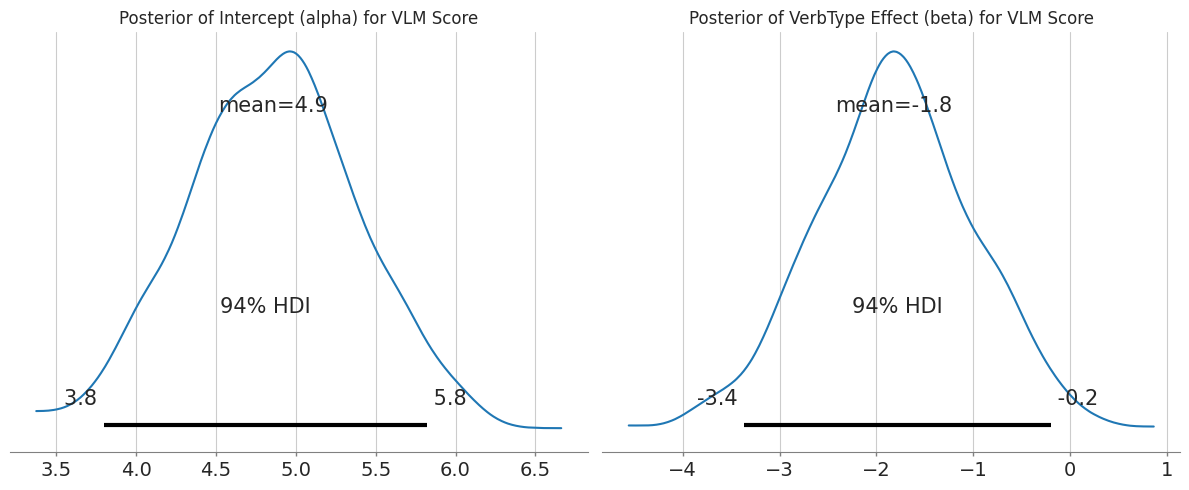


VLM Score Model Analysis:
  Posterior Mean of alpha: 4.860
  Posterior Mean of beta (VerbType effect): -1.822
  Probability (beta < 0): 0.987
  Probability (beta > 0): 0.013
  94% HPD for beta: [-3.366, -0.198]


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Get posterior samples
posterior_samples_vlm = mcmc_vlm.get_samples()

# Extract alpha and beta samples
alpha_samples_vlm = posterior_samples_vlm['alpha'].cpu().numpy()
beta_samples_vlm = posterior_samples_vlm['beta'].cpu().numpy()

# Create a dictionary for arviz.plot_posterior
data_vlm = {
    'alpha': alpha_samples_vlm,
    'beta': beta_samples_vlm
}
idata_vlm = az.from_dict(posterior=data_vlm)

# Plot posterior distributions
print("\nVisualizing Posterior Distributions for VLM Score Model...")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
az.plot_posterior(idata_vlm, var_names=['alpha'], ax=axes[0])
axes[0].set_title('Posterior of Intercept (alpha) for VLM Score')
az.plot_posterior(idata_vlm, var_names=['beta'], ax=axes[1])
axes[1].set_title('Posterior of VerbType Effect (beta) for VLM Score')
plt.tight_layout()
plt.show()

# Calculate probabilities and HPD interval for beta
p_beta_lt_zero_vlm = (beta_samples_vlm < 0).mean()
p_beta_gt_zero_vlm = (beta_samples_vlm > 0).mean()
hpd_beta_vlm = az.hdi(beta_samples_vlm, hdi_prob=0.94)

print("\nVLM Score Model Analysis:")
print(f"  Posterior Mean of alpha: {alpha_samples_vlm.mean():.3f}")
print(f"  Posterior Mean of beta (VerbType effect): {beta_samples_vlm.mean():.3f}")
print(f"  Probability (beta < 0): {p_beta_lt_zero_vlm:.3f}")
print(f"  Probability (beta > 0): {p_beta_gt_zero_vlm:.3f}")
print(f"  94% HPD for beta: [{hpd_beta_vlm[0]:.3f}, {hpd_beta_vlm[1]:.3f}]")

### Summary of Bayesian Analysis with Pyro:

This analysis investigated the effect of 'VerbType' (Unergative: -0.5, Unaccusative: 0.5) on three different outcome variables: 'CLIP_Similarity', 'Subject_Salience', and 'VLM_Score', using Bayesian modeling with Pyro.

#### 1. CLIP Similarity Model (Linear Regression):

*   **Posterior Mean of Intercept (alpha)**: 0.000 (indicating that when `VerbType` is centered, the average `CLIP_Similarity` is near zero).
*   **Posterior Mean of VerbType Effect (beta)**: -2.254
    *   This negative mean suggests that Unaccusative scenes (encoded as 0.5) are associated with a lower CLIP Similarity compared to Unergative scenes (encoded as -0.5).
*   **Probability (beta < 0)**: 0.936
    *   There is a 93.6% probability that the effect of 'VerbType' on 'CLIP_Similarity' is negative, meaning unaccusative scenes tend to have lower CLIP similarity scores.
*   **Probability (beta > 0)**: 0.064
*   **94% HPD for beta**: [-5.265, 0.348]
    *   The 94% Highest Posterior Density interval for beta includes zero, suggesting that while there's a strong tendency for a negative effect, it's not statistically significant at this credible interval level.

#### 2. Subject Salience Model (Linear Regression):

*   **Posterior Mean of Intercept (alpha)**: 0.026
*   **Posterior Mean of VerbType Effect (beta)**: -1.502
    *   This indicates that Unaccusative scenes tend to have lower Subject Salience scores compared to Unergative scenes.
*   **Probability (beta < 0)**: 0.818
    *   There is an 81.8% probability that the effect of 'VerbType' on 'Subject_Salience' is negative.
*   **Probability (beta > 0)**: 0.182
*   **94% HPD for beta**: [-4.741, 1.698]
    *   The 94% HPD interval for beta includes zero, indicating that the observed negative effect is not statistically significant.

#### 3. VLM Score Model (Ordered Logistic Regression):

*   **Posterior Mean of Intercept (alpha)**: 4.860 (representing the latent propensity when `VerbType` is centered).
*   **Posterior Mean of VerbType Effect (beta)**: -1.822
    *   This negative mean implies that Unaccusative scenes are associated with a lower latent propensity for higher VLM scores compared to Unergative scenes.
*   **Probability (beta < 0)**: 0.987
    *   There is a high probability (98.7%) that the effect of 'VerbType' on the latent propensity for 'VLM_Score' is negative, strongly suggesting that unaccusative scenes are rated lower by the VLM.
*   **Probability (beta > 0)**: 0.013
*   **94% HPD for beta**: [-3.366, -0.198]
    *   The 94% HPD interval for beta **does not include zero**, which indicates that the negative effect of 'VerbType' on 'VLM_Score' is statistically significant. Unaccusative scenes are significantly associated with lower VLM ratings.

### Overall Conclusion:

Across all three models, there is a consistent directional trend: **Unaccusative scenes tend to be associated with lower scores** in CLIP Similarity, Subject Salience, and VLM Score. While this trend is not statistically significant for CLIP Similarity and Subject Salience at the 94% HPD level (their credible intervals for `beta` include zero), the **VLM Score model shows a statistically significant negative effect of Unaccusative verb types**, with the 94% HPD interval entirely below zero. This suggests that the Qwen-VL-Chat model finds unaccusative scenes perceptually harder to interpret or verify against their descriptions than unergative scenes, aligning with the initial hypothesis that unaccusative scenes might be perceptually more challenging.

## Summary:

### Data Analysis Key Findings

The Bayesian analysis using Pyro revealed the following impacts of 'VerbType' (encoded as Unaccusative: $0.5$, Unergative: $-0.5$) on the three outcome variables:

*   **CLIP Similarity:**
    *   The posterior mean of the 'VerbType' coefficient ($\beta$) was $-2.254$, indicating that Unaccusative scenes tend to be associated with lower CLIP Similarity scores compared to Unergative scenes.
    *   There is a $93.6\%$ probability that the effect of 'VerbType' on 'CLIP\_Similarity' is negative.
    *   The $94\%$ Highest Posterior Density (HPD) interval for $\beta$ was $[-5.265, 0.348]$, which includes zero, suggesting this negative effect is not statistically significant at this credible interval level.

*   **Subject Salience:**
    *   The posterior mean of the 'VerbType' coefficient ($\beta$) was $-1.502$, suggesting that Unaccusative scenes tend to have lower Subject Salience scores than Unergative scenes.
    *   There is an $81.8\%$ probability that the effect of 'VerbType' on 'Subject\_Salience' is negative.
    *   The $94\%$ HPD interval for $\beta$ was $[-4.741, 1.698]$, which includes zero, indicating this negative effect is not statistically significant.

*   **VLM Score:**
    *   The posterior mean of the 'VerbType' coefficient ($\beta$) was $-1.822$, implying that Unaccusative scenes are associated with a lower latent propensity for higher VLM scores compared to Unergative scenes.
    *   There is a high probability ($98.7\%$) that the effect of 'VerbType' on the latent propensity for 'VLM\_Score' is negative.
    *   The $94\%$ HPD interval for $\beta$ was $[-3.366, -0.198]$, which **does not include zero**. This indicates a statistically significant negative effect, suggesting that Unaccusative scenes are significantly associated with lower VLM ratings.

### Insights or Next Steps

*   Unaccusative verb types consistently show a negative association with CLIP Similarity, Subject Salience, and VLM Scores, aligning with the hypothesis that unaccusative scenes might be perceptually more challenging.
*   The statistically significant negative effect on VLM Scores suggests that the Qwen-VL-Chat model finds unaccusative scenes notably harder to interpret or verify against their descriptions compared to unergative scenes. Further investigation could explore specific features within unaccusative scenes that lead to these lower VLM ratings.
